# Learning, Fraud Detection

In [191]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import altair as alt
alt.renderers.enable('notebook')
%env JOBLIB_TEMP_FOLDER=/tmp

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

from altair.vega import v5
from IPython.display import HTML

env: JOBLIB_TEMP_FOLDER=/tmp


In [192]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [193]:
train_identity = pd.read_csv('data/train_identity.csv')
print("Train identity:{}".format(train_identity.shape))
train_transaction = pd.read_csv('data/train_transaction.csv')
print("Train transaction:{}".format(train_transaction.shape))

Train identity:(144233, 41)
Train transaction:(590540, 394)


In [194]:
train_identity = reduce_mem_usage(train_identity)
train_transaction = reduce_mem_usage(train_transaction)

Memory usage of dataframe is 45.12 MB --> 25.86 MB (Decreased by 42.7%)
Memory usage of dataframe is 1775.15 MB --> 542.35 MB (Decreased by 69.4%)


In [195]:
# Join Transaction and Identity dataframes
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


## Feature Engineering

In [196]:
# Delete identity and transaction dataframes from memory
del train_identity, train_transaction

In [197]:
# http://localhost:8888/notebooks/IEEE-CIS%20Fraud%20Detection%20_%20EDA.ipynb
import datetime

START_DATE = '2017-11-30'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
train['Date'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
train['_ymd'] = train['Date'].dt.year.astype(str) + '-' + train['Date'].dt.month.astype(str) + '-' + train['Date'].dt.day.astype(str)
train['_year_month'] = train['Date'].dt.year.astype(str) + '-' + train['Date'].dt.month.astype(str)
train['_weekday'] = train['Date'].dt.dayofweek
train['_hour'] = train['Date'].dt.hour
train['_day'] = train['Date'].dt.day


In [198]:
# https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
# id_30 OS
train.loc[train['id_30'].str.contains('Windows', na=False), 'id_30'] = 'Windows'
train.loc[train['id_30'].str.contains('iOS', na=False), 'id_30'] = 'iOS'
train.loc[train['id_30'].str.contains('Mac OS', na=False), 'id_30'] = 'Mac'
train.loc[train['id_30'].str.contains('Android', na=False), 'id_30'] = 'Android'
train['id_30'].fillna("NAN", inplace=True)

In [199]:
train['id_30'].value_counts()

NAN        512975
Windows     36739
iOS         19782
Mac         13580
Android      6303
Linux        1136
other          15
func           10
Name: id_30, dtype: int64

In [200]:
# https://www.kaggle.com/kabure/extensive-eda-and-modeling-xgb-hyperopt
# id_31 Browser
train.loc[train['id_31'].str.contains('chrome', na=False), 'id_31'] = 'Chrome'
train.loc[train['id_31'].str.contains('firefox', na=False), 'id_31'] = 'Firefox'
train.loc[train['id_31'].str.contains('safari', na=False), 'id_31'] = 'Safari'
train.loc[train['id_31'].str.contains('edge', na=False), 'id_31'] = 'Edge'
train.loc[train['id_31'].str.contains('ie', na=False), 'id_31'] = 'IE'
train.loc[train['id_31'].str.contains('samsung', na=False), 'id_31'] = 'Samsung'
train.loc[train['id_31'].str.contains('opera', na=False), 'id_31'] = 'Opera'
train['id_31'].fillna("NAN", inplace=True)
train.loc[train.id_31.isin(train.id_31.value_counts()[train.id_31.value_counts() < 200].index), 'id_31'] = "Others"
train['id_31'].value_counts()

NAN        450258
Chrome      76059
Safari      37281
IE          10018
Firefox      7012
Edge         6401
Samsung      2044
Others        706
Opera         449
other         312
Name: id_31, dtype: int64

In [201]:
# 
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
for c in ['P_emaildomain', 'R_emaildomain']:
    train[c + '_bin'] = train[c].map(emails)
    
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    
    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    

In [202]:
train['P_emaildomain_bin'].value_counts()

google         228851
yahoo          109149
microsoft       59477
other           52868
aol             28604
apple            8225
att              7210
spectrum         1046
centurylink       654
Name: P_emaildomain_bin, dtype: int64

In [203]:
train['P_emaildomain_suffix'].value_counts()

com    466477
nan     94456
us      25038
mx       2499
es        877
de        506
fr        494
uk        161
jp         32
Name: P_emaildomain_suffix, dtype: int64

In [204]:
train.drop('TransactionID', axis=1, inplace=True)
train.drop('TransactionDT', axis=1, inplace=True)
train.drop('_ymd', axis=1, inplace=True)
train.drop('_year_month', axis=1, inplace=True)
train.drop('Date', axis=1, inplace=True)

In [205]:
cat_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 
            'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 
            'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'card1', 'card2', 'card3',  'card5', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 
            'M8', 'M9', 'P_emaildomain_bin', 'P_emaildomain_suffix', 'R_emaildomain_bin', 'R_emaildomain_suffix']
for col in cat_cols:
    if col in train.columns:
        le = preprocessing.LabelEncoder()
        le.fit(list(train[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))

In [206]:
# iterating the columns 
for col in train.columns: 
    print(col)

isFraud
TransactionAmt
ProductCD
card1
card2
card3
card4
card5
card6
addr1
addr2
dist1
dist2
P_emaildomain
R_emaildomain
C1
C2
C3
C4
C5
C6
C7
C8
C9
C10
C11
C12
C13
C14
D1
D2
D3
D4
D5
D6
D7
D8
D9
D10
D11
D12
D13
D14
D15
M1
M2
M3
M4
M5
M6
M7
M8
M9
V1
V2
V3
V4
V5
V6
V7
V8
V9
V10
V11
V12
V13
V14
V15
V16
V17
V18
V19
V20
V21
V22
V23
V24
V25
V26
V27
V28
V29
V30
V31
V32
V33
V34
V35
V36
V37
V38
V39
V40
V41
V42
V43
V44
V45
V46
V47
V48
V49
V50
V51
V52
V53
V54
V55
V56
V57
V58
V59
V60
V61
V62
V63
V64
V65
V66
V67
V68
V69
V70
V71
V72
V73
V74
V75
V76
V77
V78
V79
V80
V81
V82
V83
V84
V85
V86
V87
V88
V89
V90
V91
V92
V93
V94
V95
V96
V97
V98
V99
V100
V101
V102
V103
V104
V105
V106
V107
V108
V109
V110
V111
V112
V113
V114
V115
V116
V117
V118
V119
V120
V121
V122
V123
V124
V125
V126
V127
V128
V129
V130
V131
V132
V133
V134
V135
V136
V137
V138
V139
V140
V141
V142
V143
V144
V145
V146
V147
V148
V149
V150
V151
V152
V153
V154
V155
V156
V157
V158
V159
V160
V161
V162
V163
V164
V165
V166
V167
V168
V169
V170
V171
V172
V1

In [207]:
y = train['isFraud']
X = train.drop('isFraud', axis=1)

del train

In [208]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [209]:
X_train.fillna(X_train.mean(), inplace=True)
X_test.fillna(X_test.mean(), inplace=True)
X_train.head()

/usr/local/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,id_38,DeviceType,DeviceInfo,_weekday,_hour,_day,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix
5307,59.0000,4,9638,233,42,4,108,2,166,65,...,2,2,1742,5,0,2,4,0,6,6
191582,23.3750,0,8788,195,73,4,108,1,332,74,...,0,0,1742,3,18,18,4,0,4,0
260168,35.9375,4,2250,167,42,4,58,2,282,65,...,2,2,1742,5,2,10,4,0,6,6
18516,100.0000,2,10436,482,42,4,108,1,17,65,...,0,0,1598,1,18,5,9,8,9,8
47538,75.0000,1,5226,413,42,2,2,1,173,65,...,1,1,1297,2,0,13,4,0,4,0


In [215]:
def show_scores(y_test, y_pred):
    tp_count = 0
    fp_count = 0
    tn_count = 0
    fn_count = 0

    y_t = np.array(y_test)
    count = y_t.size

    for i in range(y_t.size):
        if y_t[i] == 1 and y_pred[i] == 1:
            tp_count += 1
        elif y_t[i] == 1 and y_pred[i] == 0:
            fn_count += 1
        elif y_t[i] == 0 and y_pred[i] == 1:
            fp_count += 1
        elif y_t[i] == 0 and y_pred[i] == 0:
            tn_count += 1

    print ("true positive {0}, false positive: {1}, false negative: {2}, true negative: {3}"
          .format(tp_count, fp_count, fn_count, tn_count))

    precision = tp_count / (tp_count + fp_count)
    recall = tp_count / (tp_count + fn_count)

    print ("Precision: {0}, Recall: {1}".format(precision, recall))

    f1 = 2 * ((precision * recall) / (precision + recall))

    print ("F1 score: {}".format(f1))

In [211]:
%%time

from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

show_scores(y_test, y_predict)

true positive 2514, false positive: 3015, false negative: 1728, true negative: 110851
Precision: 0.4546934346174715, Recall: 0.5926449787835927
F1 score: 0.5145839729812712


In [212]:
%%time

import lightgbm as lgb

params={'learning_rate': 0.01,
        'objective': 'binary',
        'metric': 'auc',
        'num_threads': -1,
        'num_leaves': 256,
        'verbose': 1,
        'random_state': 42,
        'bagging_fraction': 1,
        'feature_fraction': 0.85
       }

oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

clf = lgb.LGBMClassifier(**params, n_estimators=3000)
clf.fit(X_train, y_train)
oof_preds = clf.predict_proba(X_train, num_iteration=clf.best_iteration_)[:,1]
sub_preds = clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:,1]

CPU times: user 3h 4s, sys: 2min 8s, total: 3h 2min 12s
Wall time: 16min 35s


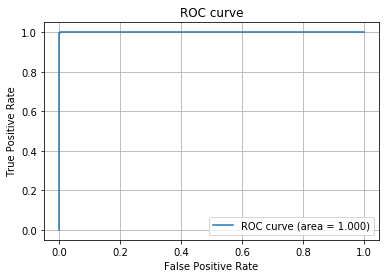

In [213]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, oof_preds)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [219]:
sub_preds.size
y_preds = [0 if pred < 0.5 else 1 for pred in sub_preds]
y_preds
show_scores(y_test, y_preds)

true positive 2451, false positive: 50, false negative: 1791, true negative: 113816
Precision: 0.9800079968012795, Recall: 0.5777934936350778
F1 score: 0.7269761233872164


In [178]:
from sklearn.model_selection import KFold,TimeSeriesSplit
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.metrics import make_scorer
## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import time
def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 7
    count=1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

    tss = TimeSeriesSplit(n_splits=FOLDS)
    y_preds = np.zeros(y_test.shape[0])
    y_oof = np.zeros(X_train.shape[0])
    score_mean = 0
    for tr_idx, val_idx in tss.split(X_train, y_train):
        clf = xgb.XGBClassifier(
            n_estimators=600, random_state=4, verbose=True, 
            tree_method='gpu_hist', 
            **params
        )

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        #y_pred_train = clf.predict_proba(X_vl)[:,1]
        #print(y_pred_train)
        score = make_scorer(roc_auc_score, needs_proba=True)(clf, X_vl, y_vl)
        # plt.show()
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


space = {
    # The maximum depth of a tree, same as GBM.
    # Used to control over-fitting as higher depth will allow model 
    # to learn relations very specific to a particular sample.
    # Should be tuned using CV.
    # Typical values: 3-10
    'max_depth': hp.quniform('max_depth', 7, 23, 1),
    
    # reg_alpha: L1 regularization term. L1 regularization encourages sparsity 
    # (meaning pulling weights to 0). It can be more useful when the objective
    # is logistic regression since you might need help with feature selection.
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    
    # reg_lambda: L2 regularization term. L2 encourages smaller weights, this
    # approach can be more useful in tree-models where zeroing 
    # features might not make much sense.
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    
    # eta: Analogous to learning rate in GBM
    # Makes the model more robust by shrinking the weights on each step
    # Typical final values to be used: 0.01-0.2
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    
    # colsample_bytree: Similar to max_features in GBM. Denotes the 
    # fraction of columns to be randomly samples for each tree.
    # Typical values: 0.5-1
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, .9),
    
    # A node is split only when the resulting split gives a positive
    # reduction in the loss function. Gamma specifies the 
    # minimum loss reduction required to make a split.
    # Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
    'gamma': hp.uniform('gamma', 0.01, .7),
    
    # more increases accuracy, but may lead to overfitting.
    # num_leaves: the number of leaf nodes to use. Having a large number 
    # of leaves will improve accuracy, but will also lead to overfitting.
    'num_leaves': hp.choice('num_leaves', list(range(20, 250, 10))),
    
    # specifies the minimum samples per leaf node.
    # the minimum number of samples (data) to group into a leaf. 
    # The parameter can greatly assist with overfitting: larger sample
    # sizes per leaf will reduce overfitting (but may lead to under-fitting).
    'min_child_samples': hp.choice('min_child_samples', list(range(100, 250, 10))),
    
    # subsample: represents a fraction of the rows (observations) to be 
    # considered when building each subtree. Tianqi Chen and Carlos Guestrin
    # in their paper A Scalable Tree Boosting System recommend 
    'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
    
    # randomly select a fraction of the features.
    # feature_fraction: controls the subsampling of features used
    # for training (as opposed to subsampling the actual training data in 
    # the case of bagging). Smaller fractions reduce overfitting.
    'feature_fraction': hp.uniform('feature_fraction', 0.4, .8),
    
    # randomly bag or subsample training data.
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, .9)
    
    # bagging_fraction and bagging_freq: enables bagging (subsampling) 
    # of the training data. Both values need to be set for bagging to be used.
    # The frequency controls how often (iteration) bagging is used. Smaller
    # fractions and frequencies reduce overfitting.
}


In [179]:
# Set algoritm parameters
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=27)

# Print best parameters
best_params = space_eval(space, best)

                                                    
############## New Run ################
params = {'max_depth': 17, 'gamma': '0.593', 'subsample': '0.40', 'reg_alpha': '0.166', 'reg_lambda': '0.199', 'learning_rate': '0.069', 'num_leaves': '110.000', 'colsample_bytree': '0.821', 'min_child_samples': '230.000', 'feature_fraction': '0.640', 'bagging_fraction': '0.867'}
  0%|          | 0/27 [00:00<?, ?it/s, best loss: ?]


XGBoostError: [20:43:33] src/learner.cc:180: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000001a1e2cf579 dmlc::LogMessageFatal::~LogMessageFatal() + 57
  [bt] (1) 2   libxgboost.dylib                    0x0000001a1e2d2e70 xgboost::LearnerImpl::ConfigureUpdaters() + 2016
  [bt] (2) 3   libxgboost.dylib                    0x0000001a1e2ca971 xgboost::LearnerImpl::Configure(std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > >, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > > > > const&) + 3633
  [bt] (3) 4   libxgboost.dylib                    0x0000001a1e2ea2eb XGBoosterUpdateOneIter + 139
  [bt] (4) 5   libffi.6.dylib                      0x000000010db6b884 ffi_call_unix64 + 76
  [bt] (5) 6   ???                                 0x00007ffee2c21770 0x0 + 140732702791536



In [174]:
from xgboost import XGBClassifier
import xgboost as xgb

clf = xgb.XGBClassifier(
    n_estimators=300,
    **best_params,
    tree_method='gpu_hist'
)

clf.fit(X_train, y_train)

y_preds = clf.predict_proba(X_test)[:,1] 

show_scores(y_test, y_preds)

NameError: name 'best_params' is not defined

In [122]:
y_score = clf.decision_function(X_test)
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

AttributeError: 'DecisionTreeClassifier' object has no attribute 'decision_function'

In [115]:
%%time

import lightgbm as lgb

params={'learning_rate': 0.01,
        'objective': 'binary',
        'metric': 'auc',
        'num_threads': -1,
        'num_leaves': 256,
        'verbose': 1,
        'random_state': 42,
        'bagging_fraction': 1,
        'feature_fraction': 0.85
       }

oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

clf = lgb.LGBMClassifier(**params, n_estimators=3000)
clf.fit(X_train, y_train)
oof_preds = clf.predict_proba(X_train, num_iteration=clf.best_iteration_)[:,1]
sub_preds = clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:,1]

CPU times: user 2h 57min 51s, sys: 1min 46s, total: 2h 59min 38s
Wall time: 15min 59s


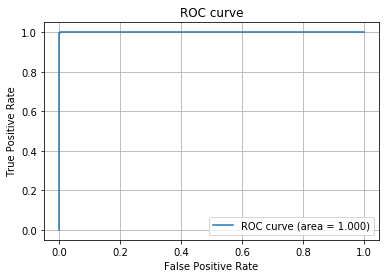

In [118]:
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_train, oof_preds)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.3f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [ ]:
Using non-engineered data only

Decision Tree

XGBoost

DNN


Using all data


Simplifying categorical data